<img style="float: right;" src="./img/es2_logo_tiny.jpg"></img>

<h1 align="center">Match Up Tool - Marine Sciences</h1>
<h2 align="center">Example Generating regression plot of insitu data vs remote sensed</h2>
<hr>

<a href="./index.ipynb"><< Index </a>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space> <a href="./Point-extract_example_marine_sciences.ipynb">02-Single-point extraction - Marine Sciences >></a>

### Background

<p>Match up services are used by scientists to both validate remote sensed data as well as in-situ data. Match ups are generated from a file of latitude, longitude and date points. These can often hold several hundred points depending on the length and purpose of the cruise that generated the in-situ data. Current methods for finding EO data matchups normally take the form of custom written scripts that have to find the most appropriate file, and within it the most appropriate pixel. This can be quite lengthy operation even when you discount the time it takes to create the script.</p>
<p>By providing a tool that can lookup values from the Ocean Colour CCI datasets we can provide a service to reduce the time needed to produce matched up datasets</p>

### Addressed Community

 * Marine and Earth Science researcher
 
### Benefits

<p>Web Coverage Service 2.0 with its processing extension Web Coverage Processing Service (WCPS) offers an efficient retrieval of single points of data without the need to download extraneous data.</p>


## Example: Produce a CSV file including the matchups from the OC-CCI daily dataset

### Description

<p> A researcher has a Comma Seperated Values (CSV) file that contains locations, dates and insitu chlorophyll measurements. They would like to query the OC-CCI Daily data to generate a corosponding CSV file that has the EO data points added</p>

<h3>Data required</h3>
<div class="alert alert-info">
<ul type="square">
<li><a href="">OC CCI Daily </a> -  Chlorophyll values matching the dates in CSV</li>
<li><b>Format:</b> NETCDF</li>
<li><b>Spatial resolution:</b> Lat/Lon grid, 4Km x 4Km</li>
<li><b>Temporal resolution:</b> Daily</li>
</ul>
</div>

<h3> Workflow - traditional </h3>
<div class="alert alert-success">
<ul type="square">
<li>(1) Retrieve data that corresponds to your spatial and temporal area</li>
<li>(2) Using a scripting language find which file is needed for  each data point</li>
<li>(3) extract pixel value using scripting language</li>
<li>(5) Plot the match up regression</li>
</ul>
</div>


This has the major overhead of needing to download a very large dataset just to get access to individual pixels. Depending on the spatial and temporal spread of inistu data points the data download could be several hundred Gb or even Tb's.

Using WCPS combined with python to parse the results can remove this need and speed up the match up process dramatically. The mechanism to do this is outline below.

#### Load required libraries

In [1]:
from __future__ import print_function
from datetime import datetime, timedelta

import csv
import requests

#### Define our  WCPS query

<p>We will use a single WCPS query multiple times, the query template will hold the coverage we want to extract from placeholders for Latitude, Lonitude and Date</p>

In [2]:
query_template = '''
for c in (V3_daily_cci_all_insitu_match_test)
return
encode (
   c[Lat({}), Long({}), ansi("{}")], "csv"
)'''

In [3]:
#### Define some helper functions

In [4]:
# This will simple create a new WCPS query using our template and given values
def create_query(lat,lon,date):
   """simply tests POST wcps requets"""
   query = query_template.format(lat,lon,date)
   return query

# This will send the WCPS query off to the web service and clean the result to a single value
def run_query(lat,lon,date):
   """simply tests POST wcps requets"""
   query = query_template.format(lat,lon,date)
   payload = {'query' : query}
   r = requests.post('http://earthserver.pml.ac.uk/rasdaman/ows/wcps'\
   , data=payload)
   return r.text[1:-1]
# This is just used to clean the dates from the CSV file and make them the format required by the web service
def clean_date(date):
   """simply return string in rasdaman approved format"""
   return datetime.strptime(date, "%d/%m/%Y").strftime("%Y-%m-%d")

# Main bulk of work is here, we loop through CSV file and get value then add back to new CSV file
# if the value is null we do not add it
def loop_csv(csv_file):
   """loops through csv list and tests each line"""
   with open(csv_file, "r") as csvfile:
      with open('output_'+csv_file, 'w') as csv_out:
         csvFile = csv.reader(csvfile, delimiter=',')
         csv_writer = csv.writer(csv_out)
         head = next(csvFile)
         head.append("match_value")
         csv_writer.writerow(head)
         x = 1
         for row in csvFile:
            d = clean_date(row[2].split(' ')[0])
            #d = clean_date(row[2])
            x = x + 1
            #q = {'query' : create_query(row[0],row[1],d)}
            #queries.append(q)
            match_value = run_query(row[0],row[1],d)
            
            if(match_value != '9.96921e+36'):
                #print(match_value)
                row.append(match_value)
                csv_writer.writerow(row)
                
                
                
                
def trendline(xd, yd, order=1, c='r', alpha=1, Rval=False):
    """Make a line of best fit"""

    #Calculate trendline
    coeffs = np.polyfit(xd, yd, order)

    intercept = coeffs[-1]
    slope = coeffs[-2]
    power = coeffs[0] if order == 2 else 0

    minxd = np.min(xd)
    maxxd = np.max(xd)

    xl = np.array([minxd, maxxd])
    yl = power * xl ** 2 + slope * xl + intercept

    #Plot trendline
    #plt.plot(xl, yl, c, alpha=alpha)

    #Calculate R Squared
    p = np.poly1d(coeffs)

    ybar = np.sum(yd) / len(yd)
    ssreg = np.sum((p(xd) - ybar) ** 2)
    sstot = np.sum((yd - ybar) ** 2)
    Rsqr = ssreg / sstot

    if not Rval:
        #Plot R^2 value
        plt.text(0.8 * maxxd + 0.2 * minxd, 0.8 * np.max(yd) + 0.2 * np.min(yd),
                 '$R^2 = %0.2f$' % Rsqr)
    else:
        #Return the R^2 value:
        return Rsqr

To run our match up now we just need to call the `loop csv` method with a path to a CSV file

In [5]:
loop_csv('cleaned_cci_db_4.csv')

## Producing the match up regression plot
<p>To do this we will use the data we generated in the previous step with a library called matplotlib.</p>

0.871923697539


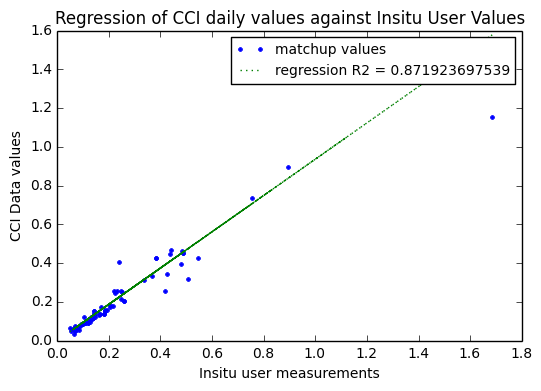

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# lists to hold data
mine = []
cci = []

with open('output_cleaned_cci_db_4.csv', 'r') as datafile:
    csvFile = csv.reader(datafile, delimiter=",")
    _ = next(csvFile)
    for row in csvFile:
        mine.append(float(row[3]))
        cci.append(float(row[4]))


mine_np = np.array(mine)

cci_np = np.array(cci)
cci_np[cci_np == 9.96921e+36] = np.nan

coeefs = np.polyfit(mine_np,cci_np, 1)
#r squared
R2 = str(trendline(mine_np,cci_np, Rval=True))
print(R2)
m, b = np.polyfit(mine_np,cci_np, 1)

plt.plot(mine_np,cci_np, '.', label="matchup values")
plt.plot(mine_np, m*mine_np + b, ':', label="regression R2 = {}".format(R2))
plt.ylabel("CCI Data values")
plt.xlabel("Insitu user measurements")
plt.title("Regression of CCI daily values against Insitu User Values")
plt.legend(prop={'size':10})

<hr>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img style="float: right" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>